# Approach



**Two-Stage Learning Framework**

Two-Stage Learning Framework (TSLF), which combines the advantages of feature-engineered models and end-to-end models. 


- In the first stage, based on deep neural networks, we calculate semantic score, coherence score and prompt-relevant score, named as Se, Ce and Pe respectively. Ce and Pe are proposed to detect adversarial samples. 

- In the second stage, we concatenate these three scores with some handcrafted features and feed the result to the boosting tree model for further training.






## Algorithm

- Convolutional Neural Network 
- Recurrent Neural Network



## Evaluation Metric

The output of an AES system can be compared to the ratings assigned by human annotators using various measures of correlation or agreement (Yannakoudakis and Cummins, 2015). These measures include 
- Pearson’s correlation
- Spearman’s correlation
- Kendall’s Tau
- **quadratic weighted Kappa (QWK)**


In order to evaluate the performance of system, we compare it to a publicly available opensource AES system called **‘Enhanced AI Scoring Engine’ (EASE)**

# 1. Data Overview

There are **eight different essay** sets which have texts ranging from 100 to 600 words. They each consist of around 1500 samples. These sets are divided according to the level of the student and the differences in their tasks. Some of them are dependent on a certain topic whereas others are general writing. They are written by students from 7th grade to 10th grade and in a score range of 0-6. 

Each of files contains 28 columns:

- essay_id: A unique identifier for each individual student essay (`could be dropped`)
- essay_set: 1-8, an id for each set of essays
- essay: The ascii text of a student's response
- rater1_domain1: Rater 1's domain 1 score; all essays have this
- rater2_domain1: Rater 2's domain 1 score; all essays have this
- rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this. (`could be dropped`)
- **domain1_score: Resolved score between the raters; all essays have this**
- rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this (`could be dropped`)
- rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this (`could be dropped`)
- domain2_score: Resolved score between the raters; only essays in set 2 have this (`could be dropped`)
- rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8 (`could be dropped`)


In [2]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk  #The Natural Language Toolkit
import tensorflow as tf

In [3]:
test = pd.read_csv("asap-aes/test_set.tsv",sep='\t', encoding='ISO-8859-1')
dev = pd.read_csv("asap-aes/valid_set.tsv",sep='\t', encoding='ISO-8859-1')
train = pd.read_csv("asap-aes/training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1')

In [27]:
# Create a dataframe for adding prompt of each essay set to get the prompt-relevant score
prompt = pd.DataFrame({"essay_set":[1,2,3,4,5,6,7,8],
                       "prompt":["More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Others have different ideas. Some experts are concerned that people are spending too much time on their computers and less time exercising, enjoying nature, and interacting with family and friends. Write a letter to your local newspaper in which you state your opinion on the effects computers have on people. Persuade the readers to agree with you.",
                                "Write a persuasive essay to a newspaper reflecting your vies on censorship in libraries. Do you believe that certain materials, such as books, music, movies, magazines, etc., should be removed from the shelves if they are found offensive? Support your position with convincing arguments from your own experience, observations, and/or reading.",
                                "Write a response that explains how the features of the setting affect the cyclist. In your response, include examples from the essay that support your conclusion.",
                                "Write a response that explains why the author concludes the story with this paragraph. In your response, include details and examples from the story that support your ideas.",
                                "Describe the mood created by the author in the memoir. Support your answer with relevant and specific information from the memoir.",
                                "Based on the excerpt, describe the obstacles the builders of the Empire State Building faced in attempting to allow dirigibles to dock there. Support your answer with relevant and specific information from the excerpt.",
                                "Write about patience. Being patient means that you are understanding and tolerant. A patient person experience difficulties without complaining.Do only one of the following: write a story about a time when you were patient OR write a story about a time when someone you know was patient OR write a story in your own way about patience.",
                                "We all understand the benefits of laughter. For example, someone once said, “Laughter is the shortest distance between two people.” Many other people believe that laughter is an important part of any relationship. Tell a true story in which laughter was one element or part."]})
prompt

,essay_set,prompt
0,1,"More and more people use computers, but not ev..."
1,2,Write a persuasive essay to a newspaper reflec...
2,3,Write a response that explains how the feature...
3,4,Write a response that explains why the author ...
4,5,Describe the mood created by the author in the...
5,6,"Based on the excerpt, describe the obstacles t..."
6,7,Write about patience. Being patient means that...
7,8,We all understand the benefits of laughter. Fo...


In [22]:
train=train[['essay_set','essay','rater1_domain1','rater2_domain1','domain1_score']]
train.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


In [23]:
train['essay'][1]

"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the i

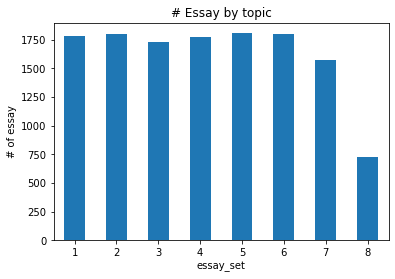

In [6]:
train.groupby('essay_set').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('# Essay by topic')
plt.ylabel('# of essay')
plt.show()

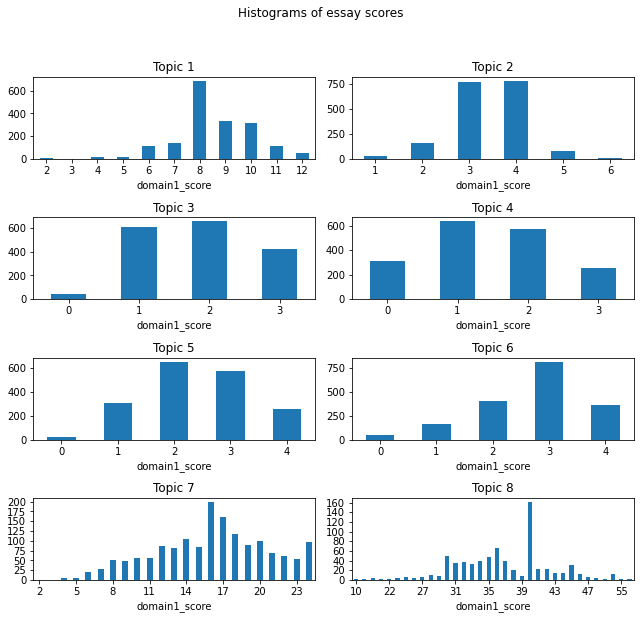

In [28]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        train[train['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_set']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [44]:
# Normalization the domain1_score
train["normalized_score"] = train["domain1_score"]  / train["domain1_score"] .abs().max()
train.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,normalized_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8,0.133333
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,0.150000
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,0.116667
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,0.166667
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,0.133333


## Prompt-relevant Score 

For a specific prompt composed of n sentences p = {s1,s2,··· ,sn} and an essay e = {s1,s2,··· ,sm} with m sentences, we first combine p and e.

In [30]:
train.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


In [38]:
train1=train.merge(prompt,on='essay_set',how='left')
# concat essay with prompt
essay_prompt = []
for i in train1["essay"]:
    for j in train1["prompt"]:
        essay_prompt.append([i,j])

In [39]:
essay_prompt[1]

["Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econo

In [45]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten,Bidirectional
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True,recurrent_dropout=0.4), input_shape=(1,50), merge_mode='concat'))
    #model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [48]:
train1.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,prompt
0,1,"Dear local newspaper, I think effects computer...",4,4,8,"More and more people use computers, but not ev..."
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,"More and more people use computers, but not ev..."
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,"More and more people use computers, but not ev..."
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,"More and more people use computers, but not ev..."
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,"More and more people use computers, but not ev..."


In [51]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
X = train1[['essay_set','essay','prompt']]
y = train1[['domain1_score']]
cv = KFold(n_splits=5, shuffle=True)
results = []
y_pred_list = []
cv_data =cv.split(X)
count = 1
print(cv_data)

<generator object _BaseKFold.split at 0x7f9e227f3cf0>


In [52]:
for traincv, testcv in cv_data:
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    num_features = 50 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3
    clean_train_essays = []
    
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords= True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays,num_features)
    
    clean_test_essays = []
    
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs(clean_test_essays,num_features)
  
    trainDataVecs = np.array(trainDataVecs)
  
    testDataVecs = np.array(testDataVecs)
    
    
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
  
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
  
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
  
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=150)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    
    y_pred = np.around(y_pred)
    
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    count = count + 1


--------Fold 1--------



NameError: name 'essay_to_wordlist' is not defined